The idea to create this model was sparked by a tweet: https://twitter.com/fchollet/status/711594805692792832

I studied the following resources to be able to finish the model:
0. http://artint.info/html/ArtInt_265.html
1. https://edersantana.github.io/articles/keras_rl/
2. http://www.nervanasys.com/demystifying-deep-reinforcement-learning/
3. http://keras.io/

Here's a gif of the model playing a few games of catching fruit:
<img src="files/fruit.gif" />

Btw, I really, *really* liked Eder Santana's idea to apply big idea's to toy examples. I hope to do this more often to feed my fingerspitzengefühl.

In [1]:
from random import sample as rsample

import numpy as np

from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten
from keras.layers import Input
from keras.optimizers import SGD, RMSprop
from keras import backend as K
import gym
import matplotlib.pyplot as plt
from skimage import color
from scipy.misc import imresize


%matplotlib inline

K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
env = gym.make('Breakout-v0')
print env.observation_space

img = env.reset()
print img.shape

def grayAndResize(img):
    gray = color.rgb2grey(img)
    newImg = imresize(gray, (84, 84))
    return newImg

def stackIt(images):
    stage = np.zeros(shape = (4, 84, 84))
    for k, img in enumerate(images):
        stage[k] = grayAndResize(img)
    return stage

[2017-04-06 18:23:38,080] Making new env: Breakout-v0


Box(210, 160, 3)
(210, 160, 3)


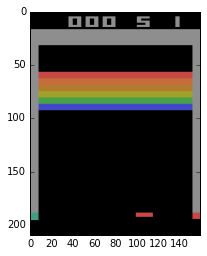

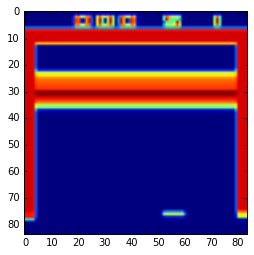

6
(84, 84) (4, 84, 84)


In [3]:
plt.imshow(img)
plt.show()

images = stackIt([img, img, img, img])

images = images

plt.imshow(images[0])
plt.show()
print env.action_space.n
print images[0].shape, images.shape

In [4]:
           
def experience_replay(batch_size):
    """
    Coroutine of experience replay.
    
    Provide a new experience by calling send, which in turn yields 
    a random batch of previous replay experiences.
    """
    memory = []
    while True:
        experience = yield rsample(memory, batch_size) if batch_size <= len(memory) else None
        memory.append(experience)


In [7]:
def build_model(STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT, output_size ,dir = None):
    model = Sequential()
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4),border_mode='same', activation='relu', input_shape=(STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT)))
    model.add(Convolution2D(32, 4, 4, subsample=(2, 2), border_mode='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(output_size))
    
    return model

In [8]:
nb_epochs = 1000
batch_size = 128
epsilon = .8
gamma = .8
K_frames = 4 #frames to skip each step

# Recipe of deep reinforcement learning model
model = Sequential()
model.add(Convolution2D(16, nb_row=3, nb_col=3, input_shape=(4, 84, 84), activation='relu'))
model.add(Convolution2D(16, nb_row=3, nb_col=3, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3))

#model  = build_model(STATE_LENGTH = K_frames, FRAME_WIDTH = 84, FRAME_HEIGHT = 84,output_size=env.action_space.n)
model.compile(RMSprop(), 'MSE')

exp_replay = experience_replay(batch_size)
exp_replay.next()  # Start experience-replay coroutine

for i in xrange(nb_epochs):
    #ep = episode()
    #S, won = ep.next()  # Start coroutine of single entire episode
    action = np.random.randint(0, 6) #first action of epoch is random
    S = env.reset()
    loss = 0.
    try:
        while True:
            action = np.random.randint(0, 6) 
            if np.random.random() > epsilon:
                # Get the index of the maximum q-value of the model.
                # Subtract one because actions are either -1, 0, or 1 #DONT DO THAT
                
                ls = list()
                ls.append(S)
                for i in range(K_frames-1):
                    s, r, done, info = env.step(action)
                    ls.append(s)
                S = stackIt(ls)
                
                action = np.argmax(model.predict(S)) 
            
            
            ls = list()
            ls.append(S)
            
            for i in range(K_frames-1):
                s, r, done, info = env.step(action)
                ls.append(s)
            S_prime = stackIt(ls)
            
            #S_prime, r, done, info = env.step(action)
            
            experience = (S, action, r, S_prime)
            S = S_prime
            
            batch = exp_replay.send(experience)
            
            if batch:
                inputs = []
                targets = []
                for s, a, r, s_prime in batch:
                    # The targets of unchosen actions are the q-values of the model,
                    # so that the corresponding errors are 0. The targets of chosen actions
                    # are either the rewards, in case a terminal state has been reached, 
                    # or future discounted q-values, in case episodes are still running.
                    t = model.predict(s)
                    t[a] = r
                    if not r:
                        t[a] = r + gamma * np.argmax(model.predict(s_prime))
                    targets.append(t)
                    inputs.append(s)
                
                loss += model.train_on_batch(np.array(inputs), np.array(targets))

    except StopIteration:
        pass
    
    if (i + 1) % 100 == 0:
        print 'Epoch ', i + 1, 'loss:', loss


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), padding="same", strides=(4, 4), activation="relu", input_shape=(4, 84, 84...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), padding="same", strides=(2, 2), activation="relu")`
  after removing the cwd from sys.path.


ValueError: Error when checking : expected conv2d_2_input to have 4 dimensions, but got array with shape (4, 84, 84)

In [28]:
print model.layers[0]

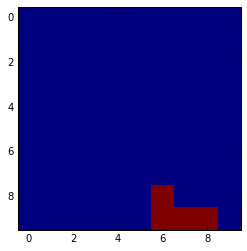

In [5]:
def save_img():
    frame = 0
    while True:
        screen = (yield)
        plt.imshow(screen[0], interpolation='none')
        plt.savefig('images/%03i.png' % frame)
        frame += 1
    
img_saver = save_img()
img_saver.next()

for _ in xrange(10):
    g = episode()
    S, _ = g.next()
    img_saver.send(S)
    try:
        while True:
            act = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1
            S, _ = g.send(act)
            img_saver.send(S)

    except StopIteration:
        g.close()

img_saver.close()
